## Učitavanje biblioteka i podataka

In [122]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_predict
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA

In [124]:
file_path = "heart.csv"
df = pd.read_csv(file_path)

[ https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction ]

## Osnovni pregled i struktura podataka

Pre detaljne analize, neophodno je steći osnovni uvid u strukturu skupa podataka.
U ovom koraku ispituju se dimenzije podataka, tipovi atributa i osnovni primeri zapisa.
Ova analiza omogućava identifikaciju potencijalnih problema kao što su neodgovarajući tipovi podataka,
nedostajuće vrednosti ili neočekivane kolone, koje mogu predstavljati izvor šuma.

In [128]:
display(df.head())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [130]:
df.shape

(918, 12)

In [132]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [134]:
df['HeartDisease'].unique() # target

array([0, 1], dtype=int64)

In [136]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [138]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

In [140]:
num_cols = numeric_df.columns

## Deskriptivna statistika numeričkih atributa

Deskriptivna statistika se koristi za analizu osnovnih statističkih karakteristika numeričkih atributa,
kao što su srednja vrednost, standardna devijacija, minimum i maksimum.
Ovi pokazatelji omogućavaju uočavanje raspona vrednosti, varijabilnosti podataka,
kao i potencijalnih ekstremnih vrednosti koje mogu predstavljati šum u podacima.

In [143]:
display(numeric_df.describe())

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Nekoliko vrednosti ukazuju na potencijalni šum, odnosno na greške u podacima ili ekstremne autlajere koji nisu fiziološki mogući:

1. **RestingBP** (resting blood pressure [mm Hg])

* **Problem:** Minimalna vrednost (`min`) je **0.000000**.
* **Objašnjenje:** Živa osoba ne može imati krvni pritisak 0. Ovo je klasičan primer "šuma" ili nedostajuće vrednosti koja je greškom upisana kao nula.

2. **Cholesterol** (serum cholesterol [mm/dl])

* **Problem:** Minimalna vrednost (`min`) je **0.000000**.
* **Objašnjenje:** Biološki je nemoguće imati nivo holesterola 0 u krvi. Takođe, standardna devijacija (`std`) od **109.38**, što je veoma visoko u odnosu na prosek (`mean`) od **198**. To ukazuje na prisustvo nula koje vuku prosek nadole.

3. **Oldpeak** (oldpeak = ST [Numeric value measured in depression])

* **Problem:** Minimalna vrednost (`min`) je **-2.600000**.
* **Objašnjenje:** `Oldpeak` se u kardiološkim setovima podataka obično meri od nule nagore. Negativne vrednosti se često smatraju anomalijama ili greškama u unosu.

---

## Vizuelizacija raspodele numeričkih atributa

Vizuelizacija raspodele numeričkih atributa omogućava intuitivno sagledavanje oblika distribucije podataka.
Histogrami pomažu u identifikaciji asimetričnih raspodela, prisustva outliera i koncentracije vrednosti,
što su česti izvori šuma u realnim skupovima podataka.

In [147]:
def plot_numeric_distributions(df, num_cols, cols_per_row=4, bins=20, figsize_per_col=4):
    
    num_plots = len(num_cols)
    rows = math.ceil(num_plots / cols_per_row)
    layout_tuple = (rows, cols_per_row)
    figsize = (cols_per_row * figsize_per_col, rows * figsize_per_col)
    
    fig, axes = plt.subplots(rows, cols_per_row, figsize=figsize)
    
    if rows * cols_per_row > 1:
        axes = axes.flatten()
    elif rows == 1 and cols_per_row == 1:
        axes = [axes]
    else:
        axes = axes.ravel()
    
    for i, col in enumerate(num_cols):
        sns.histplot(
            data=df,
            x=col,
            ax=axes[i],
            kde=True,
            bins=bins,
            color='skyblue',
            stat='count'
        )
        
        for line in axes[i].lines:
            if line.get_linestyle() == '-' and line.get_linewidth() > 1:
                line.set_color('red')
                break
        
        axes[i].set_title(f'Distribucija: {col}', fontsize=12)
        axes[i].set_xlabel('')
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Histogram distribucije (Seaborn + crvena KDE linija)', fontsize=18, y=0.98)
    plt.show()

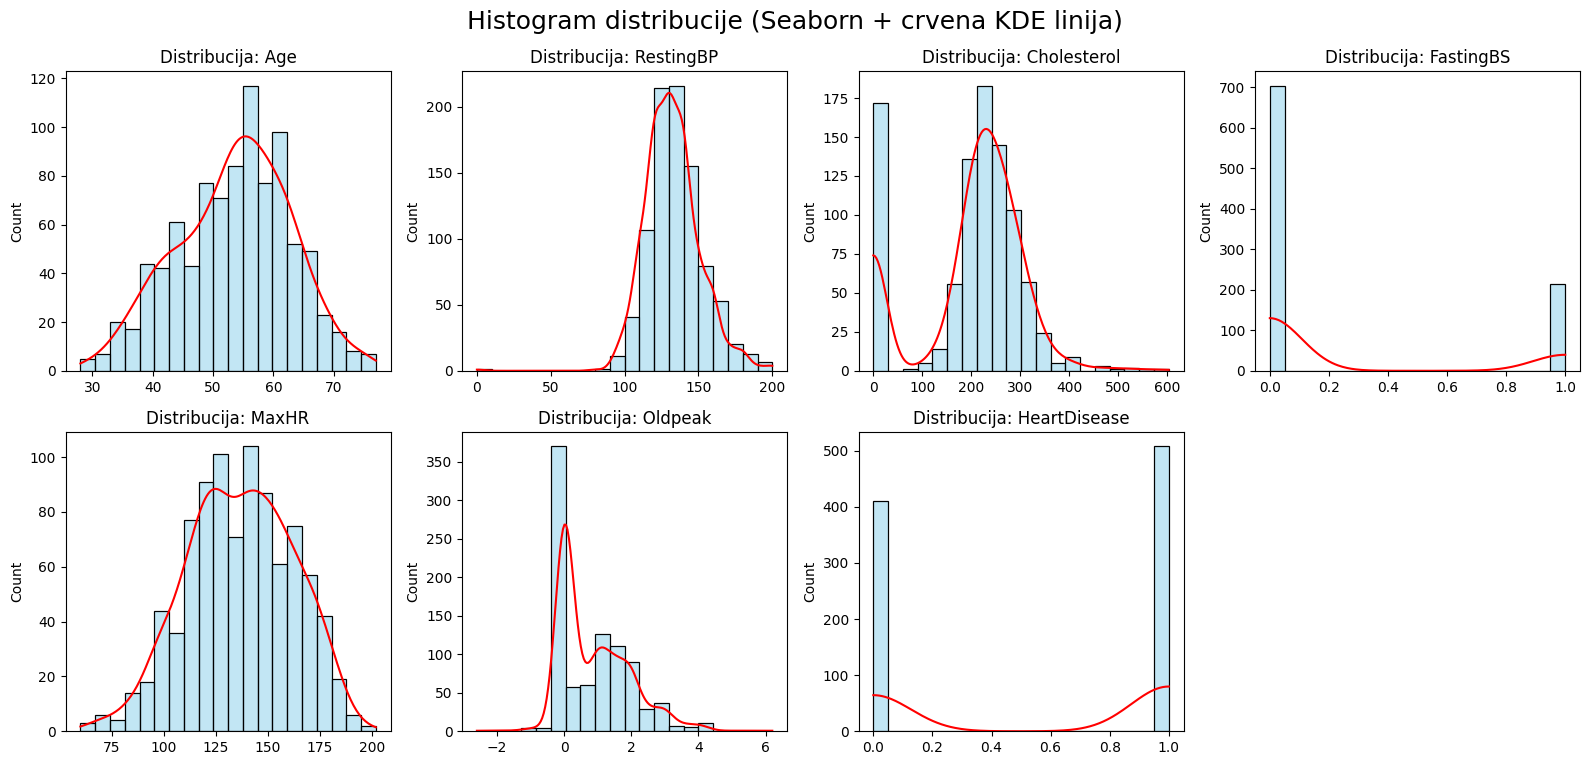

In [149]:
plot_numeric_distributions(numeric_df, numeric_df.columns)

Ovi histogrami jasno vizuelizuju probleme koje smo primetili u tabeli, ali sada možemo videti i **obim** tih problema (koliko često se pojavljuju).

Evo šta se jasno vidi kao "šum" ili sumnjiva vrednost na grafikonima:

1. Ogroman "skok" na nuli kod `Cholesterol`

Postoji značajan broj pacijenata (preko 175) kojima je holesterol upisan kao 0. S obzirom na to da je ostatak distribucije lep "zvono" (normalna distribucija) sa centrom oko 200-250, ovi nulti podaci su verovatno nedostajuće vrednosti koje kvare analizu.

2. Usamljena tačka na nuli kod `RestingBP`

Na grafikonu , skroz levo, vidi se jedan sićušan stubić na nuli.
To je onaj jedan podatak sa vrednošću 0 koji smo videli u tabeli. On je autlajer jer se nalazi miljama daleko od glavne grupe podataka koja počinje tek od oko 80-90 mmHg.

3. Negativne vrednosti kod `Oldpeak`-a

Grafikon pokazuje da to nije samo jedan slučajan podatak, već postoji mali klaster vrednosti ispod nule.

#### Bimodalna distribucija (`FastingBS` i `HeartDisease`)

Ovo nije nužno šum.

Ovo su **kategoričke (binarne) promenljive**, a ne kontinuirane, iako su prikazane na numeričkoj skali. Kod njih šum ne bi bio u vidu ekstremnih brojeva, već u vidu pogrešne klasifikacije (npr. ako je neko dobio 1, a zapravo je 0), što se iz histograma ne vidi.

---

## Analiza kategorijalnih atributa

U ovom delu analize ispituje se raspodela vrednosti kategorijalnih atributa.
Cilj je da se identifikuje eventualna neuravnoteženost klasa ili retke kategorije,
koje mogu negativno uticati na modele i povećati nivo šuma u podacima.

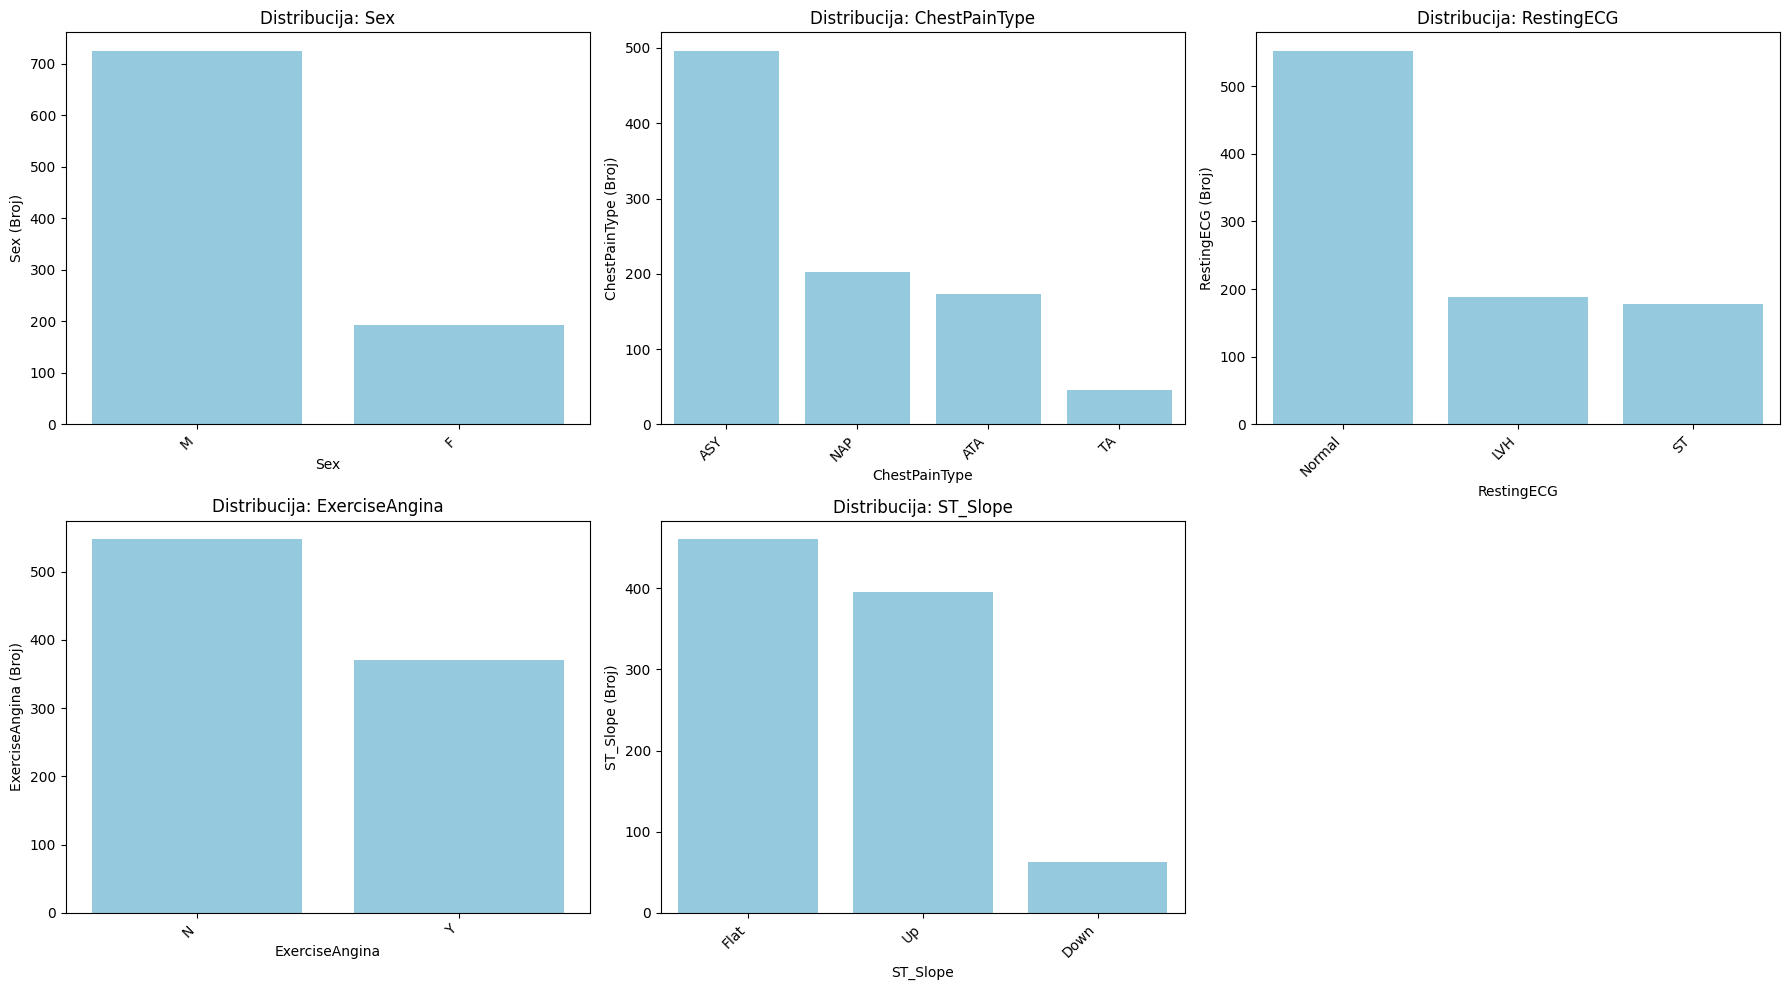

In [152]:
nonnumerical_df = df.select_dtypes(exclude="number")
cols = nonnumerical_df.columns
num_columns = len(cols)

cols_per_row = 3 
rows = (num_columns + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(6 * cols_per_row, 5 * rows)) 

for i, col in enumerate(cols):
    plt.subplot(rows, cols_per_row, i + 1)
    
    sns.countplot(
            data=df,
            x=df[col].astype(str),
            color='skyblue',
            order=df[col].value_counts().index
        )
    
    plt.title(f'Distribucija: {col}')
    plt.xlabel(col)
    plt.ylabel(f'{df[col].name} (Broj)') 
    plt.xticks(rotation=45, ha='right') 

plt.tight_layout() 
plt.show()

Podaci koji mogu biti šumni:

1. Klasa **TA** u `ChestPainType`

Kategorija **TA** ima značajno manje unosa u odnosu na **ASY**, **NAP** i **ATA**.
Ovako mali broj uzoraka može biti šuman jer model neće imati dovoljno primera da nauči kako se pacijenti sa **TA** ponašaju.

2. Klasa **Down** u `ST_Slope`

3. Disproporcija u `Sex`

Može uvesti **pristrasnost**.

---

## Korelaciona analiza numeričkih atributa

Korelaciona analiza se koristi za ispitivanje međusobnih odnosa između numeričkih atributa.
Atributi sa visokom međusobnom korelacijom mogu biti redundantni,
dok atributi sa veoma slabom korelacijom mogu doprineti šumu.
Vizuelizacija korelacione matrice olakšava interpretaciju ovih odnosa
i predstavlja osnovu za dalju selekciju i transformaciju podataka.

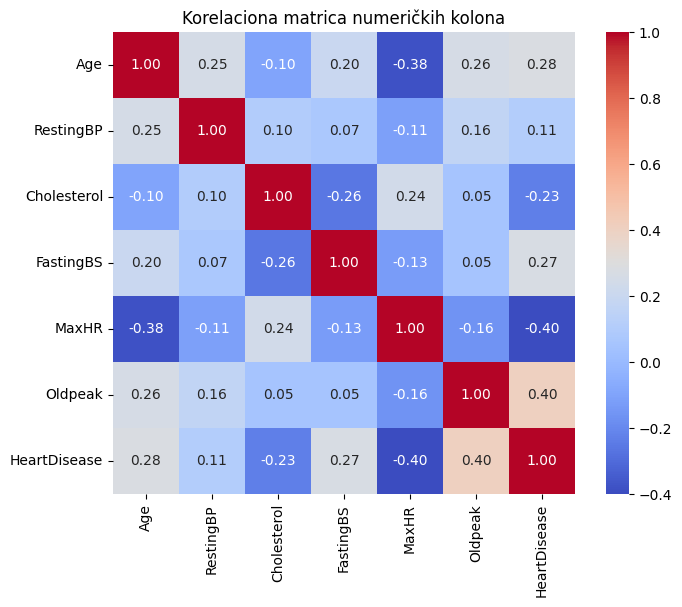

In [156]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Korelaciona matrica numeričkih kolona")
plt.show()

1. `Cholesterol` i `HeartDisease` (negativna korelacija: -0.23)

Matrica pokazuje da kako holesterol raste, verovatnoća srčanog oboljenja opada (negativna korelacija). Sa medicinske tačke gledišta, ovo je besmisleno.
Nule u holesterolu (šum) veštački stvaraju sliku da ljudi sa niskim holesterolom imaju srčane probleme, čime se kvari stvarna korelacija.

2. `RestingBP` i `HeartDisease` (slaba korelacija: 0.11)

Korelacija od samo 0.11 je veoma niska za krvni pritisak, koji je obično značajan faktor rizika.
Nula koju smo uočili smanjuje statističku značajnost ove kolone.

3. `Oldpeak` i `HeartDisease` (jaka korelacija: 0.40)

Smislena korelacija, ali negativne vrednosti u `Oldpeak` smanjuju korelaciju, pa i značaj kolone.

---

## Box-plot analiza 

Omogućava potvrdu prethodno uočenih obrazaca i potencijalnih izvora šuma.

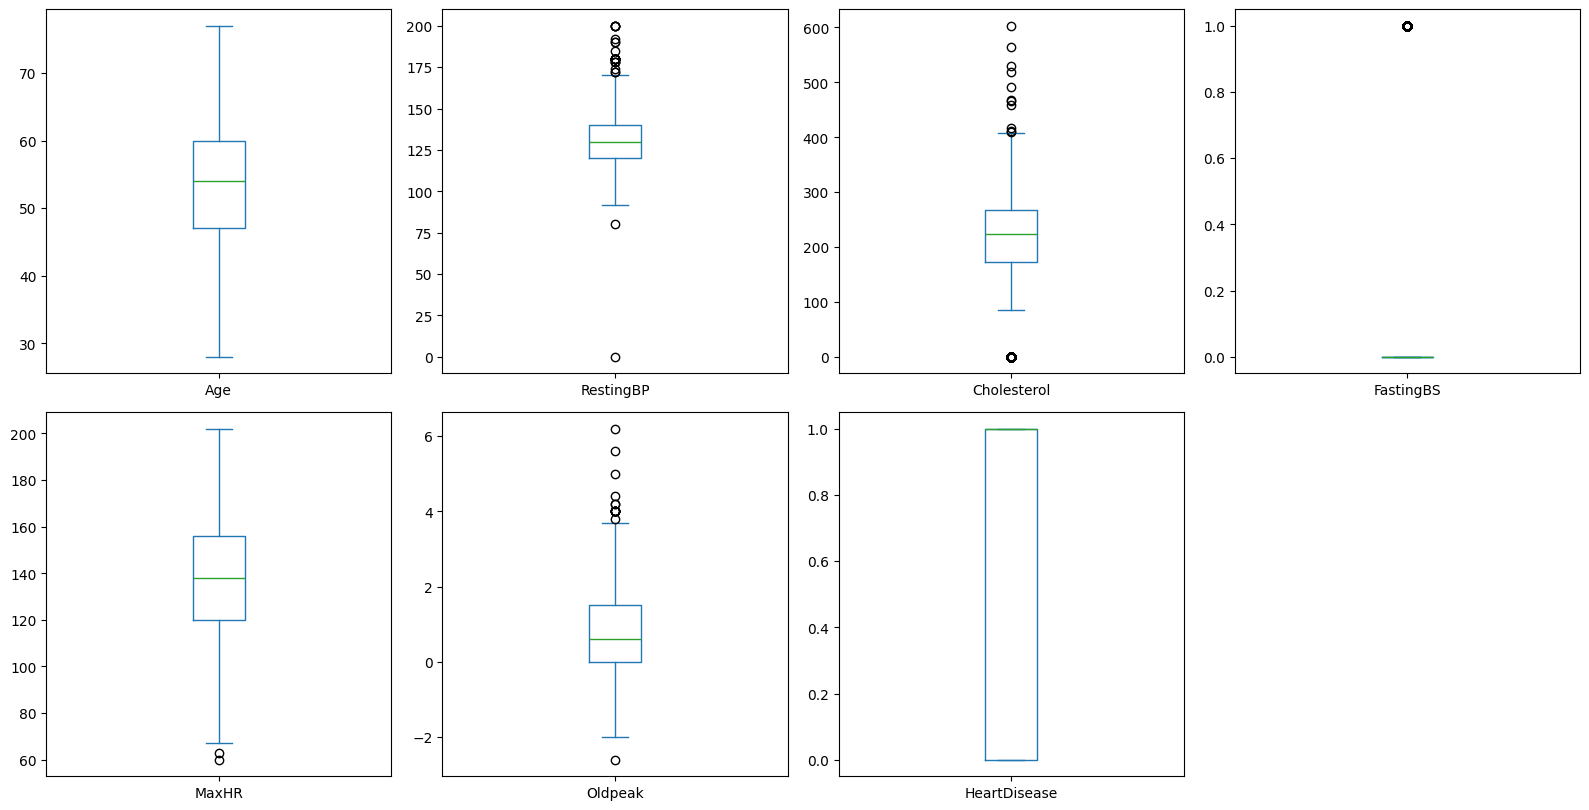

In [161]:
ncols = 4
nrows = int(np.ceil(df.shape[1] / ncols))

df.plot(kind='box', subplots=True, layout=(nrows, ncols), figsize=(16, 4*nrows), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Evo kako ovi grafikoni potvrđuju postojanje šuma:

1. Potvrda nemogućih nula (`RestingBP` i `Cholesterol`)

2. Potvrda negativnih vrednosti (`Oldpeak`)

Na grafikonu za **Oldpeak**, jasno se vidi kružić ispod nule (kod **-2.6**). To potvrđuje da to nije deo normalne distribucije, već statistički incident u ovom skupu podataka.

---

In [163]:
df_encoded = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

In [166]:
df_encoded.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_F', 'Sex_M', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

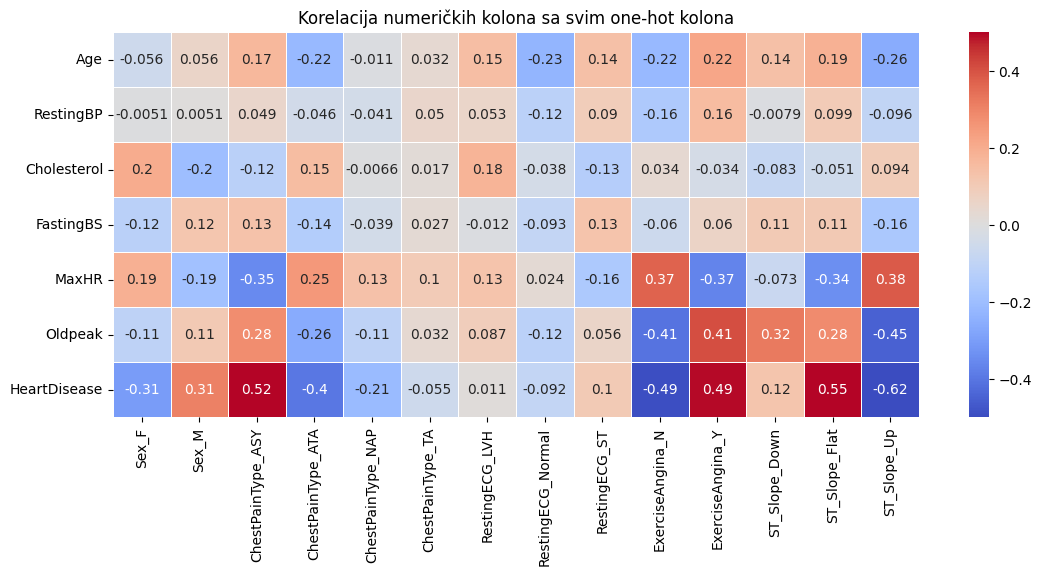

In [168]:
correlation_matrix = df_encoded.corr()

numerical_cols = df_encoded.select_dtypes(include=['number']).columns

one_hot_cols = [col for col in df_encoded.columns if '_' in col and col not in numerical_cols]

corr_subset = correlation_matrix.loc[numerical_cols, one_hot_cols]

plt.figure(figsize=(13, 5))
sns.heatmap(
    corr_subset,
    annot=True,
    cmap='coolwarm',
    center=0,
    vmin=-0.5,
    vmax=0.5,
    linewidths=0.5
)
plt.title('Korelacija numeričkih kolona sa svim one-hot kolona')
plt.show()

1. Čisti prediktori sa najjačim signalom

Ove kolone imaju veoma visoke korelacije sa `HeartDisease`, što znači da je šum u njima nizak ili zanemarljiv:

**`ST_Slope_Up` (-0.62) i `ST_Slope_Flat` (0.55)**
**`ExerciseAngina_Y` (0.49) i `ChestPainType_ASY` (0.52)**

2. Potvrda šuma u koloni `Cholesterol`

Korelacije sa svim ostalim faktorima su **izuzetno niske** (npr. sa `ChestPainType_ASY` je **-0.12**).
U medicini, visok holesterol je često povezan sa drugim faktorima rizika. Činjenica da on ovde ne reaguje skoro ni na šta statistički potvrđuje da su one **nule** koje smo videli na histogramu potpuno ubile informativnu vrednost ove kolone.

3. `Oldpeak` korelacije

Ima jaku negativnu korelaciju sa `ST_Slope_Up` (**-0.45**).
Ovo nam govori da je, uprkos onim negativnim vrednostima (poput **-2.6**), ova kolona i dalje veoma moćna. Ipak, čišćenjem tih par negativnih autlajera, ovi koeficijenti bi postali još stabilniji.

---
**Kategorički šum:** Kategorija `ChestPainType_TA` ima korelaciju od samo **-0.055**. To potvrđuje našu sumnju sa bar-charta: te kategorije ima premalo da bi bila statistički značajna (šum zbog malog uzorka).

---

## Treniranje modela i evaluacija performansi

Definisana funkcija za treniranje i evaluaciju modela koristi se kao standardizovana procedura evaluacije i pokreće se nakon primene različitih metoda uklanjanja šuma, kako bi se omogućilo objektivno poređenje njihovog uticaja na performanse klasifikacionog modela.

In [172]:
def TrainAndReturnSpecs(df):
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred,zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    classes = np.unique(y_test)
    if len(classes) == 1:
        roc_auc = 0
    else:
        y_proba = model.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_proba)

    res = {
        'df':df,
        'accuracy':acc,
        'precision':precision,
        'recall':recall,
        'f1':f1,
        'roc_auc':roc_auc
    }

    return res

In [174]:
ref_dict=dict()
ref_dict['WithNoise']= TrainAndReturnSpecs(df_encoded)

## Metode uklanjanja šuma

U nastavku rada biće primenjene sledeće metode uklanjanja šuma iz podataka:

- Binning
- Regresija
- IQR
- LocalOutlierFactor
- IsolationForest
- KMeans
- Ensemble Filter
- CrossValidatedCommittees Filter
- IterativePartitioning Filter

Svaka od navedenih metoda biće posebno analizirana, a njihov uticaj na performanse modela biće evaluiran primenom iste procedure treniranja i testiranja, kao i uklanjanje duplikata i redukcija dimenzionalnosti.

# Binning

#### Zašto `smooth_by_means_per_bin` za **`RestingBP`**?

Na osnovu histograma za **`RestingBP`**:

* Normalna distribucija
* Odsustvo ekstremnih autlajera (osim nule)
* Kada je raspodela simetrična i nema mnogo ekstremnih vrednosti koje vuku prosek, aritmetička sredina (`mean`) je najbolja jer uzima u obzir doprinos svake vrednosti.

#### Zašto `smooth_by_medians_per_bin` za **`Oldpeak`** i **`Cholesterol`**?

**Za `Cholesterol`:**

* Histogram pokazuje ogroman broj nula i veoma dugačak rep sa desne strane
* Srednja vrednost (`mean`) bi bila drastično povučena nadole zbog onih 170+ nula ili nagore zbog ekstremnih vrednosti od 600.
* Medijana (`median`) je imuna na ove ekstremne tačke; ona bira središnju vrednost i tako ignoriše šum, zadržavajući tipičnu vrednost za taj bin.

**Za `Oldpeak`:**

* Oldpeak ima specifičnu raspodelu gde je većina vrednosti 0, a zatim opada ka većim brojevima, uz prisustvo onih sumnjivih negativnih vrednosti
* Pošto Oldpeak meri nivo depresije, medijana bolje čuva stepenastu prirodu ovog merenja i sprečava da par ekstremno visokih ili negativnih vrednosti unutar jednog k-means bin-a veštački promene nivo te grupe.

#### Zašto ne `smooth by boundaries`?

Kao što smo videli na box-plotovima, dataset ima dosta autlajera (kružića van brkova).

* Ako koristimo *smooth by boundaries*, a bin sadrži autlajer, taj autlajer postaje jedna od granica.

Histogrami pokazuju da podaci imaju jasne centre (vrhove na KDE crvenoj liniji).

* **Smooth by boundaries* gura podatke ka ivicama bina, stvarajući veštačke "praznine" u sredini distribucije.

U kodu koristimo `strategy="kmeans"` u `KBinsDiscretizer`.

* K-means već grupiše podatke oko centroida (centra).

In [179]:
def smooth_by_means_per_bin(values, original_values):
    smoothed = np.zeros_like(values, dtype=float)
    for b in np.unique(values):
        mask = values == b
        smoothed[mask] = np.mean(original_values[mask])
    return smoothed

def smooth_by_medians_per_bin(values, original_values):
    smoothed = np.zeros_like(values, dtype=float)
    for b in np.unique(values):
        mask = values == b
        smoothed[mask] = np.median(original_values[mask])
    return smoothed


df_binning = df_encoded.copy()

eq = KBinsDiscretizer(n_bins=30, encode="ordinal", strategy="kmeans")
cols_to_bin = ['Oldpeak', 'Cholesterol', 'RestingBP'] 

eq.fit(df_binning[cols_to_bin])
binned_data = eq.transform(df_binning[cols_to_bin])
df_binned = pd.DataFrame(binned_data, columns=cols_to_bin, index=df_binning.index)
df_binning[cols_to_bin] = df_binned

df_binning['Oldpeak'] = smooth_by_medians_per_bin(df_binning['Oldpeak'].values, df_encoded['Oldpeak'].values)
df_binning['Cholesterol'] = smooth_by_medians_per_bin(df_binning['Cholesterol'].values, df_encoded['Cholesterol'].values)
df_binning['RestingBP'] = smooth_by_means_per_bin(df_binning['RestingBP'].values, df_encoded['RestingBP'].values)

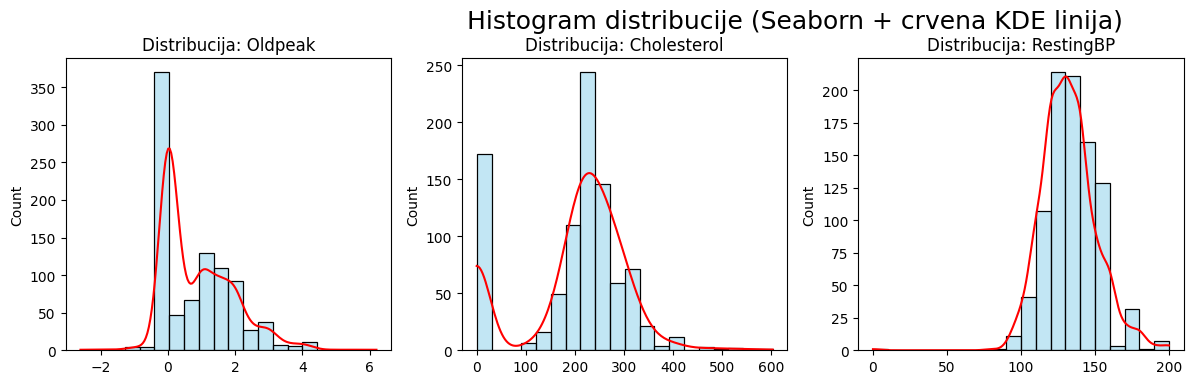

In [181]:
plot_numeric_distributions(df_binning, cols_to_bin)

In [182]:
ref_dict['Binning']= TrainAndReturnSpecs(df_binning)

# Regression


Koristimo linearnu regresiju da zamenimo originalne vrednosti u kolonama `Oldpeak`, `Cholesterol` i `RestingBP` predviđenim vrednostima na osnovu ostalih karakteristika. Cilj je smanjenje šuma.

In [187]:
df_reg = df_encoded.copy()

for col in cols_to_bin:
    X_features = df_reg.drop(columns=[col])
    y_target = df_reg[col]

    model = LinearRegression()
    model.fit(X_features, y_target)

    df_reg[col] = model.predict(X_features)

In [189]:
ref_dict['Regression']= TrainAndReturnSpecs(df_reg)

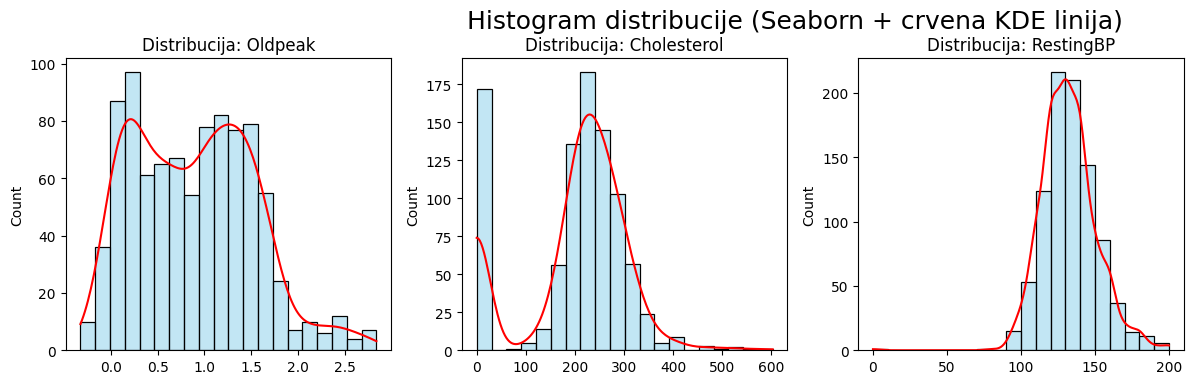

In [190]:
plot_numeric_distributions(df_reg, cols_to_bin)

# Outlier analysis

## IQR

Ova ćelija identifikuje i uklanja ekstremne vrednosti iz kolona `Oldpeak`, `Cholesterol`, `RestingBP` i `MaxHR` (`MaxHR` je na boxplotu imao autlejere). Koristimo metodu IQR kako bismo zadržali samo podatke koji se nalaze unutar granica.

In [196]:
noisy_cols = cols_to_bin + ['MaxHR']
df_iqr = df_encoded.copy()

for col in noisy_cols:
    Q1 = df_iqr[col].quantile(0.25)
    Q3 = df_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_iqr = df_iqr[(df_iqr[col] >= lower_bound) & (df_iqr[col] <= upper_bound)]


In [198]:
ref_dict['IQR']= TrainAndReturnSpecs(df_iqr)

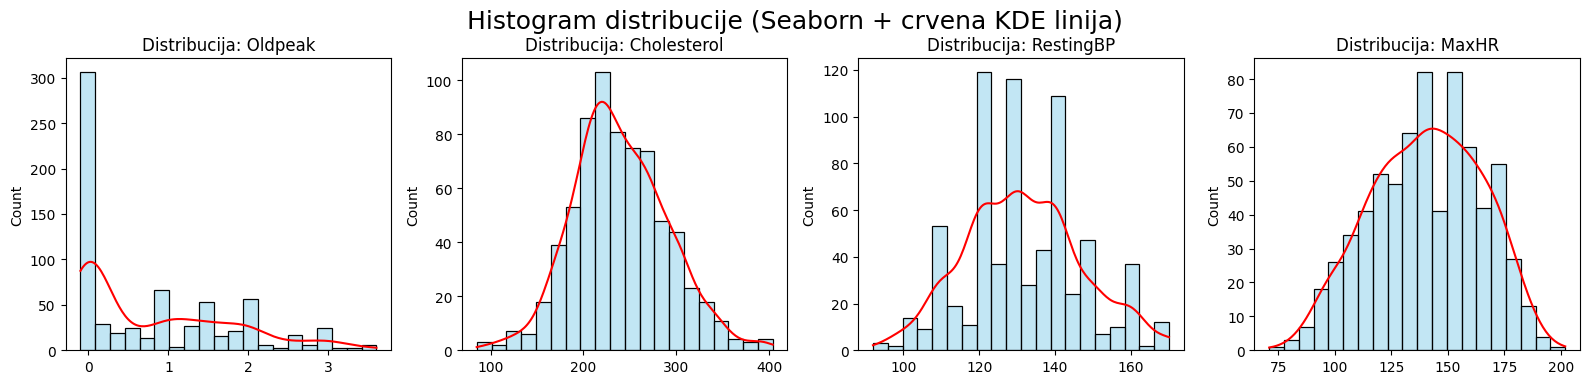

In [200]:
plot_numeric_distributions(df_iqr, noisy_cols)

## LocalOutlierFactor

LOF metoda identifikuje i uklanjanja složene autlajere koji se ne mogu uočiti prostim posmatranjem jedne kolone. Podaci se prvo standardizuju, a zatim algoritam uklanja 5% najsumnjivijih redova (anomalija) na osnovu gustine njihovog okruženja.

In [204]:
df_locoutfac = df_encoded.copy()

X_values = df_locoutfac[noisy_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_values)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X_scaled)

df_locoutfac = df_locoutfac.iloc[y_pred != -1].copy()

X_scaled_clean = X_scaled[y_pred != -1]
df_locoutfac[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

In [206]:
ref_dict['LocalOutlierFactor']= TrainAndReturnSpecs(df_locoutfac)

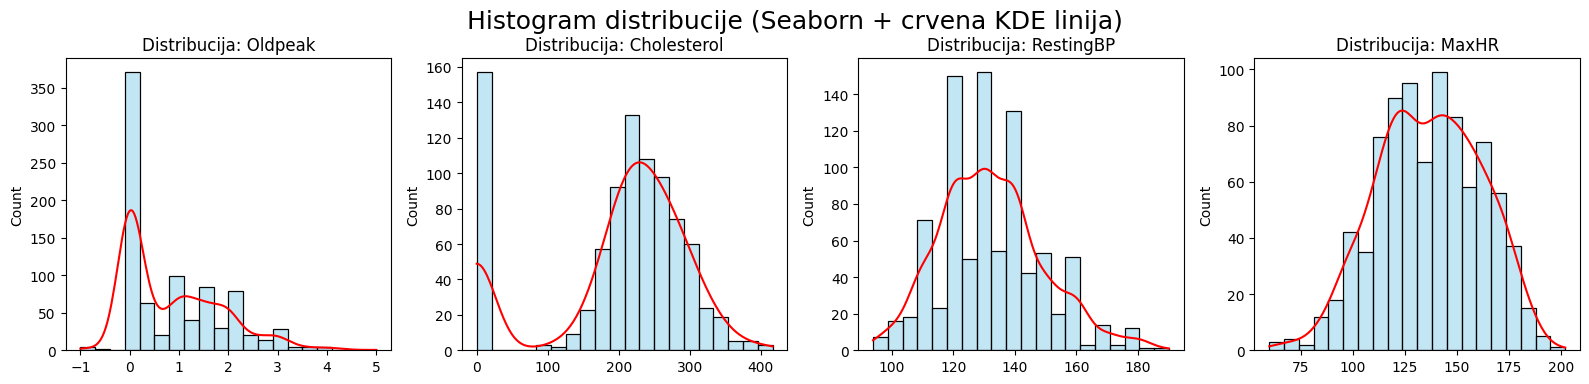

In [207]:
plot_numeric_distributions(df_locoutfac, noisy_cols)

## IsolationForest

Algoritam IsolationForest identifikuje autlajere. Princip rada se zasniva na izolovanju anomalija pomoću nasumičnog deljenja prostora podataka. Pošto su anomalije retke i udaljene, one se lakše (brže) izoluju od ostatka podataka. Uklanjamo 5% najsumnjivijih primera.

In [211]:
df_iforest = df_encoded.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_iforest[noisy_cols])

iso_forest = IsolationForest(contamination=0.05, random_state=42)
y_pred = iso_forest.fit_predict(X_scaled)

mask = y_pred != -1

df_iforest = df_iforest.iloc[mask].copy()

X_scaled_clean = X_scaled[mask]
df_iforest[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

In [213]:
ref_dict['IsolationForest']= TrainAndReturnSpecs(df_iforest)

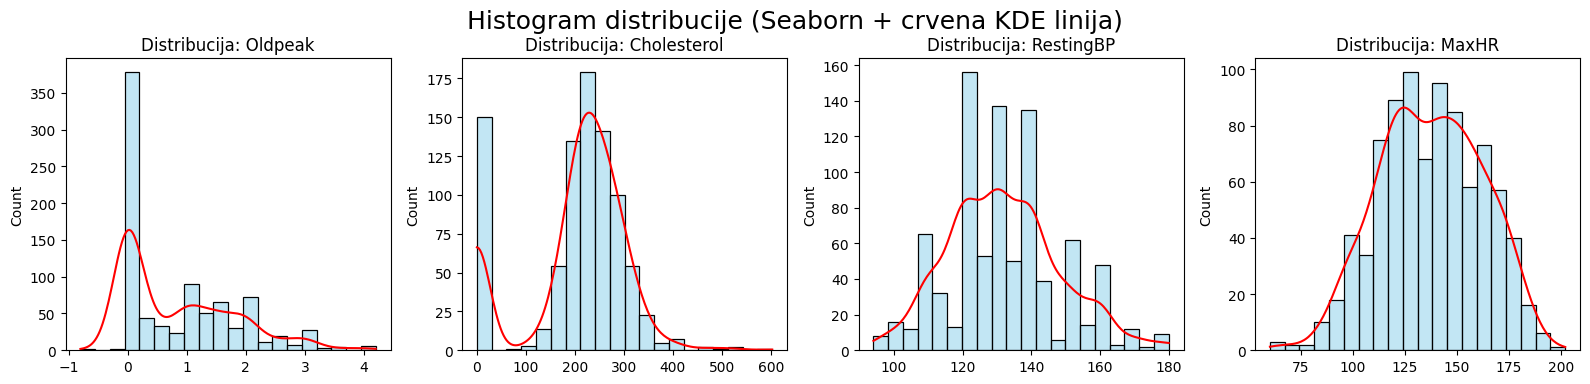

In [215]:
plot_numeric_distributions(df_iforest, noisy_cols)

## KMeans

Anomalije identifikujemo kao tačke koje su najviše udaljene od centra svog dodeljenog klastera. Uklanjamo 5% podataka koji imaju najveće euklidske udaljenosti od svojih centroida (iznad 95. percentila).

In [219]:
df_kmeans = df_encoded.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans[noisy_cols])

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

threshold = np.percentile(distances, 95)

mask = distances <= threshold

df_kmeans = df_kmeans.iloc[mask].copy()

X_scaled_clean = X_scaled[mask]
df_kmeans[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

In [220]:
ref_dict['KMeans']= TrainAndReturnSpecs(df_kmeans)

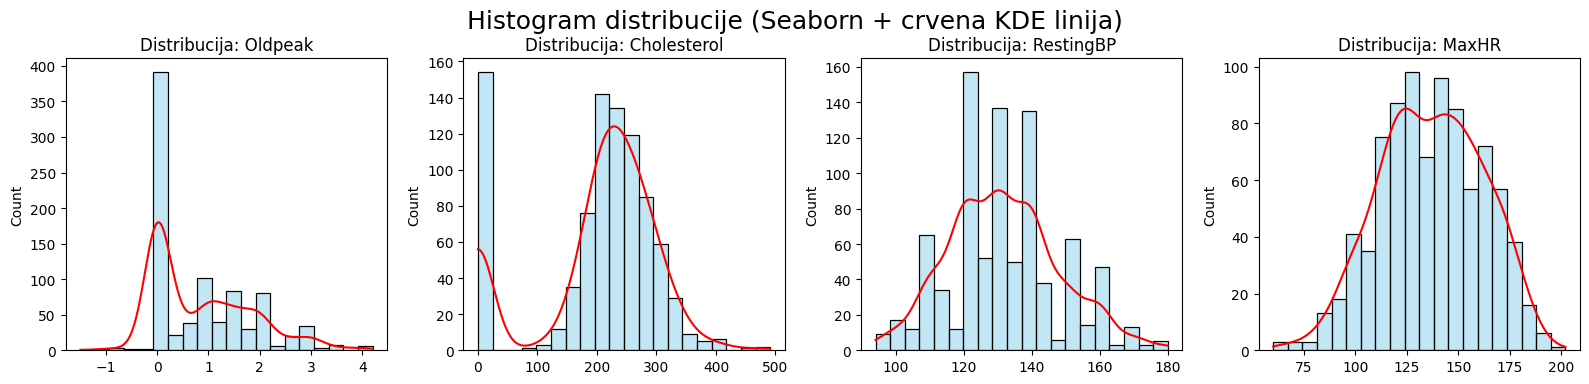

In [221]:
plot_numeric_distributions(df_kmeans, noisy_cols)

# Filters

## Ensemble

Ova metoda koristi tri različita algoritma (`Random Forest`, `Gradient Boosting` i `Logistic Regression`) da identifikuje problematične redove. Ako većina modela (više od 50%) pogreši u predviđanju labele za određeni red, taj red se smatra šumom ili anomalijom i uklanja se iz skupa podataka.

In [229]:
filter_algorithms = [
    RandomForestClassifier(n_estimators=50, random_state=42),
    GradientBoostingClassifier(random_state=42),
    make_pipeline(StandardScaler(),
                  LogisticRegression(solver="liblinear", max_iter=5000, random_state=42))
]

X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_filtered = X.copy()
y_filtered = y.copy()

misclassified_counts = np.zeros(len(X_filtered))

for clf in filter_algorithms:
    clf.fit(X_filtered, y_filtered)
    y_pred = clf.predict(X_filtered)
    misclassified_counts += (y_pred != y_filtered)

threshold = len(filter_algorithms) // 2
mask = misclassified_counts <= threshold

X_clean = X_filtered[mask].copy()
y_clean = y_filtered[mask].copy()

X_clean = X_clean.reset_index(drop=True)
y_clean = y_clean.reset_index(drop=True)
df_ensembl = X_clean.copy()
df_ensembl['HeartDisease'] = y_clean

In [231]:
ref_dict['Ensemble']= TrainAndReturnSpecs(df_ensembl)

## CrossValidatedCommittees

Ansambl modela i `cross_val_predict` identifikovaje primere koje je teško klasifikovati. Za razliku od običnog filtra, ovde svaki model predviđa labele za podatke koje nije video tokom treninga. Ako većina modela (glasanjem) pogreši, taj red se uklanja kao potencijalni šum ili nepouzdana informacija.

In [235]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_filtered = X.copy()
y_filtered = y.copy()

misclassified_counts = np.zeros(len(X_filtered))

for clf in filter_algorithms:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X_filtered, y_filtered, cv=skf)
    misclassified_counts += (y_pred != y_filtered)

threshold = len(filter_algorithms) // 2  
mask = misclassified_counts <= threshold

X_clean = X_filtered[mask].copy()
y_clean = y_filtered[mask].copy()

X_clean = X_clean.reset_index(drop=True)
y_clean = y_clean.reset_index(drop=True)
df_crossval = X_clean.copy()
df_crossval['HeartDisease'] = y_clean

In [236]:
ref_dict['CrossValidatedCommittees']= TrainAndReturnSpecs(df_crossval)

## IterativePartitioning

U svakom krugu, podaci se dele na $\gamma$ delova (K-Fold), a `DecisionTreeClassifier` identifikuje primere kod kojih se predviđena labela ne slaže sa stvarnom. Proces se ponavlja sve dok broj detektovanih šumnih podataka ne padne ispod definisanog praga ($p$).

In [240]:
def iterative_partitioning_filter(X, y, max_iter=10, gamma=5, p=0.01, y_fraction=0.05):
    # p: prag (% originalnog skupa) ispod koga se filter zaustavlja
    # y_fraction: procenat "dobrih" instanci koji se uklanja u svakoj iteraciji
    
    X, y = np.array(X), np.array(y)
    n = len(y)
    DT = np.arange(n)  # indeksi preostalih instanci
    
    for iteration in range(max_iter):
        print(f"\n=== Iteracija {iteration+1} ===")
        
        kf = KFold(n_splits=gamma, shuffle=True, random_state=iteration)
        preds = np.zeros((len(DT), gamma), dtype=object)
        
        for i, (train_idx, val_idx) in enumerate(kf.split(DT)):
            train_ids, val_ids = DT[train_idx], DT[val_idx]
            clf = DecisionTreeClassifier(random_state=iteration)
            clf.fit(X[train_ids], y[train_ids])
            preds[val_idx, i] = clf.predict(X[val_ids])
        
        maj_preds = [] # većinsko glasanje
        for i in range(len(DT)):
            votes, counts = np.unique(preds[i], return_counts=True)
            maj_preds.append(votes[np.argmax(counts)])
        maj_preds = np.array(maj_preds)
        
        noisy_idx = DT[maj_preds != y[DT]]
        good_idx = DT[maj_preds == y[DT]]
        
        print(f"Detektovano šumnih instanci: {len(noisy_idx)}")
     
        if len(noisy_idx) < p * n:
            print("Zaustavljam - broj šumnih ispod praga.")
            break
        
        n_good_remove = int(len(DT) * y_fraction) 
        if n_good_remove > 0:
            good_remove = np.random.choice(good_idx, size=n_good_remove, replace=False)
        else:
            good_remove = np.array([])
       
        remove_idx = np.concatenate([noisy_idx, good_remove])
        DT = np.setdiff1d(DT, remove_idx)  # DT ← DT \ {DN ∪ DG}
        print(f"Nakon uklanjanja ostalo: {len(DT)} instanci")
    
    return X[DT], y[DT]

In [243]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

max_iter = 10
gamma = 5          
p = 0.01           
y_fraction = 0.05  

X_clean, y_clean = iterative_partitioning_filter(X, y, max_iter=max_iter, gamma=gamma, p=p, y_fraction=y_fraction)

X_clean = pd.DataFrame(X_clean, columns=X.columns).reset_index(drop=True)
y_clean = pd.Series(y_clean, name='HeartDisease').reset_index(drop=True)
df_ipf = pd.concat([X_clean, y_clean], axis=1)

print(f"\nOriginalni dataset: {len(df_encoded)} instanci")
print(f"Pročišćeni dataset: {len(df_ipf)} instanci")


=== Iteracija 1 ===
Detektovano šumnih instanci: 508
Nakon uklanjanja ostalo: 365 instanci

=== Iteracija 2 ===
Detektovano šumnih instanci: 0
Zaustavljam - broj šumnih ispod praga.

Originalni dataset: 918 instanci
Pročišćeni dataset: 365 instanci


In [245]:
ref_dict['IterativePartitioning']= TrainAndReturnSpecs(df_ipf)

# Uklanjanje duplikata

## Exact Duplicates

In [249]:
df_encoded.duplicated().sum()

0

## Near Duplicates

Koristimo kombinovanu metriku: Euklidsku udaljenost za numeričke podatke i Hammingovu udaljenost za kategorijske za uklanjanje skoro-duplikata. Ako su dva reda u oba smisla ispod definisanog praga (`threshold`), jedan od njih se uklanja kako bi se smanjila redundantnost i sprečila pristrasnost modela.

In [253]:
df_tmp = df.copy()

cat_cols = df_tmp.select_dtypes(include=["object"]).columns.tolist()
num_cols = df_tmp.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
num_data = scaler.fit_transform(df_tmp[num_cols]) if num_cols else np.array([])

# 3️Kategorijske kolone → Hamming distance
cat_data = df_tmp[cat_cols].fillna("").astype(str).values if cat_cols else np.array([])

num_threshold = 0.5      # Euclidean distance u standardizovanoj skali
cat_threshold = 0.1      # <=10% kategorijskih kolona se razlikuje

to_drop = set()
n = len(df_tmp)

for i in range(n):
    for j in range(i+1, n):
        
        # Numeričke kolone
        flag_num = False
        if num_cols:
            dist = np.linalg.norm(num_data[i] - num_data[j])
            flag_num = dist < num_threshold

        # Kategorijske kolone
        flag_cat = False
        if cat_cols:
            diff = np.mean(cat_data[i] != cat_data[j])  # Hamming distance
            flag_cat = diff <= cat_threshold

        # Kombinacija: ukloni ako su blizu u obe dimenzije
        if flag_num and flag_cat:
            to_drop.add(j)
            
df_neardup = df_encoded.copy()
df_neardup = df_neardup.drop(index=list(to_drop)).reset_index(drop=True)

print("Broj uklonjenih redova:", len(to_drop))

Broj uklonjenih redova: 25


In [254]:
ref_dict['NearDuplicates']= TrainAndReturnSpecs(df_neardup)

# Dimension reduction

## Feature Selection - embedded

Koristimo logističku regresiju sa $L_1$ penalom kako bismo identifikovali najznačajnije prediktore za srčana oboljenja. $L_1$ regularizacija vrši unutrašnju selekciju tako što kažnjava nebitne atribute i postavlja njihove koeficijente na nulu, ostavljajući nam samo najinformativniji podskup podataka u `df_reduced`.

In [258]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

model = LogisticRegression(penalty='l1', solver='liblinear')  # L1 penal
model.fit(X.values, y)

selector = SelectFromModel(model, prefit=True)
X_selected = selector.transform(X.values)
selected_features = X.columns[selector.get_support()]

In [259]:
df_reduced = pd.concat([pd.DataFrame(X_selected, columns=selected_features), y.reset_index(drop=True)], axis=1)

In [260]:
ref_dict['DimensionReduction']= TrainAndReturnSpecs(df_reduced)

# Poređenje rezultata

In [296]:
df_results = pd.DataFrame(ref_dict).T  # transpose da su metode po redovima
df_results = df_results.drop(columns=['df'])
df_results = df_results.apply(pd.to_numeric)

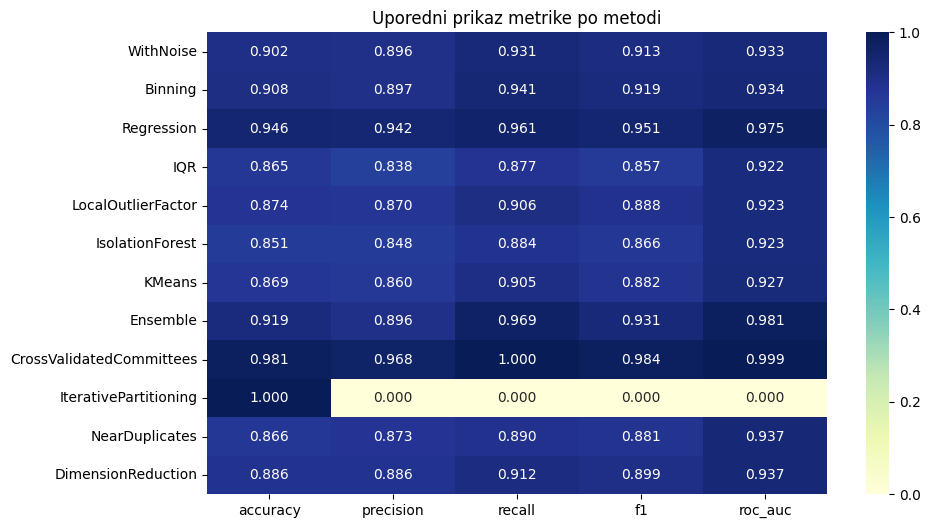

In [298]:
plt.figure(figsize=(10,6))
sns.heatmap(df_results, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Uporedni prikaz metrike po metodi")
plt.show()

In [300]:
df_ranks = df_results.rank(ascending=False, method='min')  # veće je boljec
df_ranks['sum_rank'] = df_ranks.sum(axis=1)  # ukupan rank
df_ranks.sort_values('sum_rank')

,accuracy,precision,recall,f1,roc_auc,sum_rank
CrossValidatedCommittees,2.0,1.0,1.0,1.0,1.0,6.0
Regression,3.0,2.0,3.0,2.0,3.0,13.0
Ensemble,4.0,4.0,2.0,3.0,2.0,15.0
Binning,5.0,3.0,4.0,4.0,6.0,22.0
WithNoise,6.0,4.0,5.0,5.0,7.0,27.0
DimensionReduction,7.0,6.0,6.0,6.0,4.0,29.0
LocalOutlierFactor,8.0,8.0,7.0,7.0,10.0,40.0
NearDuplicates,10.0,7.0,9.0,9.0,5.0,40.0
KMeans,9.0,9.0,8.0,8.0,8.0,42.0
IterativePartitioning,1.0,12.0,12.0,12.0,12.0,49.0
